In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [7]:
PATH = "/storage/data/planets/"

In [27]:
ls {PATH}

__MACOSX/     test-tif-v2.tar           train-jpg.tar     train-tif-v2.tar
test-jpg/     test_v2_file_mapping.csv  train-jpg.tar.7z  train_v2.csv
test-tif-v2/  train-jpg/                train-tif-v2/


In [22]:
from fastai.plots import *

In [23]:
def get_1st(path): return glob(f'{path}/*.*')[0]

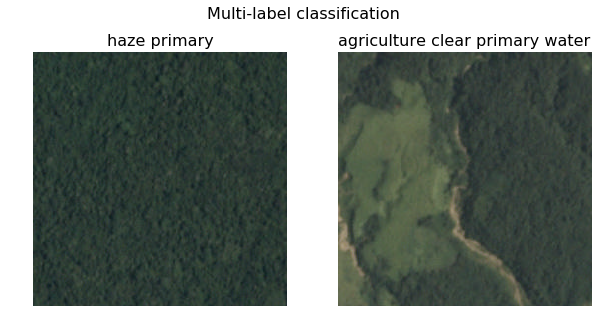

In [50]:
list_paths = [f"{PATH}train-jpg/train_10007.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [34]:
from sklearn.metrics import fbeta_score as f2

metrics = [f2]
f_model = resnet34

In [44]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [45]:
n

40479

In [51]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                                        suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [52]:
data = get_data(256)

- Multi-label classification cannot be done with Keras style approach where subfolder is the name of the label. So we use from_csv
- transform_top_down : it does more than just a vertical flip. There are 8 possible symmetries for a square — it can be rotated through 0, 90, 180, 270 degrees and for each of those, it can be flipped (dihedral group of eight)

In [ ]:
x,y = next(iter(data.val_dl))

- We had seen data.val_ds , test_ds, train_ds(ds: dataset) for which you can get an individual image by data.train_ds[0], for example.
- dl is a data loader which will give you a mini-batch, specifically transformed mini-batch. With a data loader, you cannot ask for a particular mini-batch; you can only get back the next mini-batch. In Python, it is called “generator” or “iterator”. PyTorch really leverages modern Python methodologies.

In [ ]:
y

- x : a mini-batch of images, 
- y : a mini-batch of labels.

In [ ]:
list(zip(data.classes, y[0]))

Behind the scenes, PyTorch and fast.ai are turning our labels into one-hot-encoded labels.

In [ ]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

- *1.4 : The image was washed out, so making it more visible (“brightening it up a bit”). Images are just matrices of numbers, so we can do things like this.
- It is good to experiment images like this because these images are not at all like ImageNet. The vast majority of things you do involving convolutional neural net will not actually be anything like ImageNet (medical imaging, classifying different kinds of steel tube, satellite images, etc)

In [ ]:
sz=64

data = get_data(sz)
data = data.resize(int(sz*1.3), 'tmp')

- We will not use sz=64 for cats and dogs competition because we started with pre-trained ImageNet network which starts off nearly perfect. If we re-trained the whole set with 64 by 64 images, we would destroy the weights that are already very good. Remember, most of ImageNet models are trained with 224 by 224 or 299 by 299 images.

- There is no images in ImageNet that looks like the one above. And only the first couple layers are useful to us. So starting out with smaller images works well in this case.

In [ ]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 0.2
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

[lr/9, lr/3, lr] — this is because the images are unlike ImageNet image and earlier layers are probably not as close to what they need to be.


In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

## Visualizing the layers

In [ ]:
learn.summary()